In [1]:
%matplotlib inline

import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.constants import c

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
pwr = np.fromfile('meridian_pwr.f32', dtype = 'float32')
pwr /= np.median(pwr)
T = 100e-6
t = np.arange(pwr.size) * T

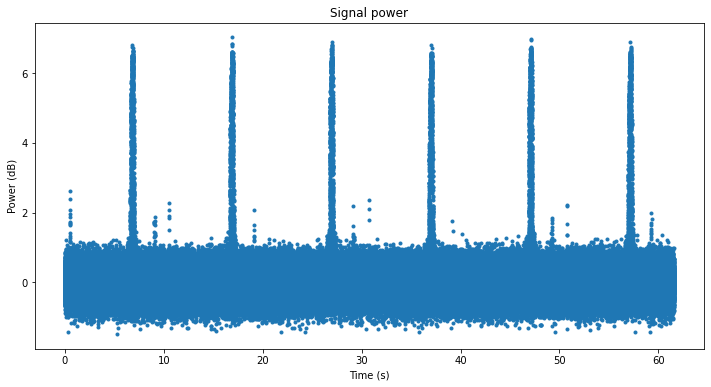

In [3]:
plt.plot(t, 10 * np.log10(pwr), '.')
plt.title('Signal power')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)');

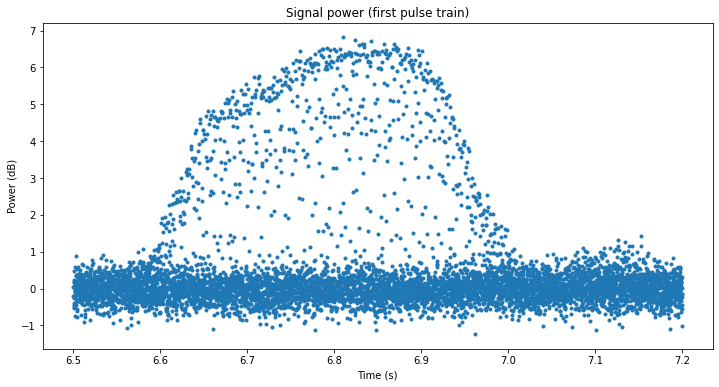

In [4]:
sel = slice(65000,72000)
plt.plot(t[sel], 10 * np.log10(pwr[sel]), '.')
plt.title('Signal power (first pulse train)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)');

In [5]:
fs = 2e6
start = 6.5
end = 7.1
duration = end - start
x = np.fromfile('/home/daniel/Descargas/gqrx_20210117_223857_994299999_2000000_fc.raw',
               dtype = 'complex64', offset = 8 * int(fs * start),
               count = int(fs * duration))

x = scipy.signal.resample_poly(x, 4, 1)
fs *= 4

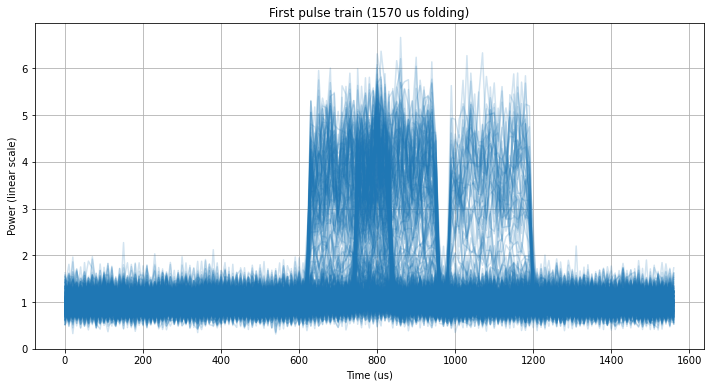

In [6]:
avg = 20*4
fold = 4*3140//avg
xp = x[80*avg:] # drop some sample to center the graph
xp = np.average(np.abs(xp[:xp.size//avg*avg].reshape((-1,avg)))**2, axis = 1)
xp /= np.median(xp)
xp_fold = xp[:xp.size//fold*fold].reshape((-1,fold))
tau = np.arange(xp_fold.shape[1])/(fs/avg)
plt.plot(tau * 1e6, xp_fold.T, '-', color = 'C0', alpha = 0.2)
plt.xlabel('Time (us)')
plt.ylabel('Power (linear scale)')
plt.grid()
plt.title('First pulse train (1570 us folding)');

In [7]:
fold_t = fold * avg / fs
fold_t

0.00157

In [8]:
fold_f = 1/fold_t
fold_f

636.9426751592357

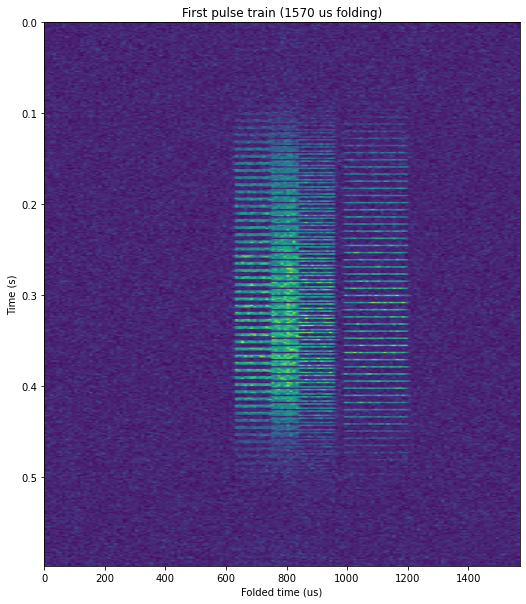

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(xp_fold, aspect = 3e3, extent = (0, 1570, xp_fold.shape[0]*fold_t, 0))
plt.title('First pulse train (1570 us folding)')
plt.ylabel('Time (s)')
plt.xlabel('Folded time (us)');

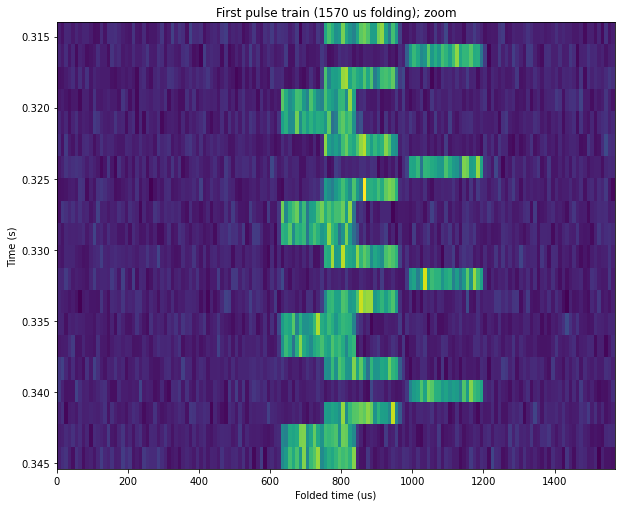

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(xp_fold[200:220], aspect = 4e4, extent = (0, 1570, 220*fold_t, 200*fold_t))
plt.title('First pulse train (1570 us folding); zoom')
plt.ylabel('Time (s)')
plt.xlabel('Folded time (us)');

In [11]:
y = x[2100*256*4:2200*256*4]

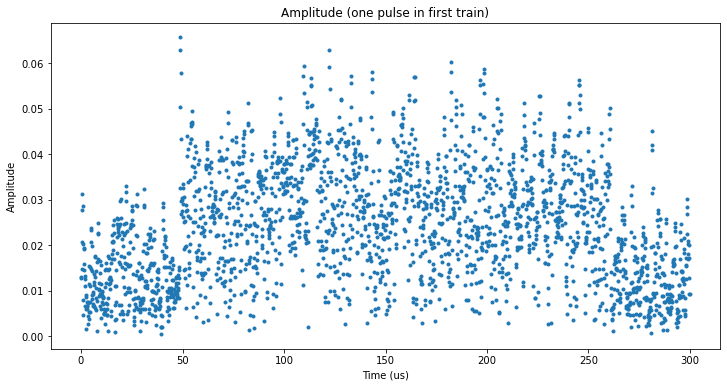

In [12]:
sel = slice(14900*4,15500*4)
plt.plot(np.arange(y[sel].size)/fs*1e6, np.abs(y[sel]), '.')
plt.title('Amplitude (one pulse in first train)')
plt.ylabel('Amplitude')
plt.xlabel('Time (us)');

-91666.66666666667

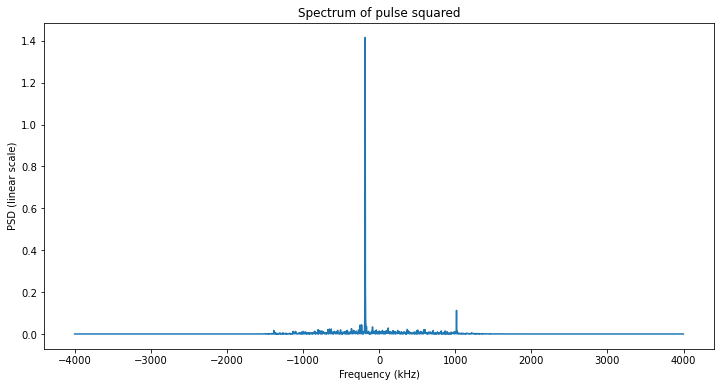

In [13]:
z = y[sel]
freqs = np.fft.fftfreq(z.size, 1/fs)
fzsq = np.abs(np.fft.fft(z**2))**2
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(fzsq))
plt.title('Spectrum of pulse squared')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (linear scale)')
f_offset = freqs[np.argmax(fzsq)]/2
f_offset

In [14]:
z0 = z * np.exp(-1j*2*np.pi*f_offset/fs*np.arange(z.size))

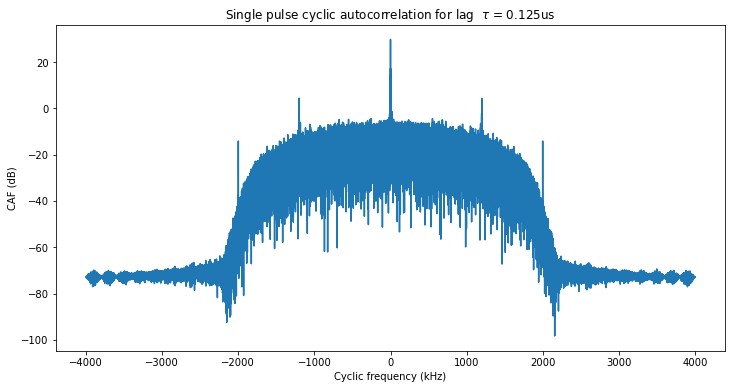

In [15]:
g = 20*np.log10(np.abs(np.fft.fft(y[1:] * np.conjugate(y[:-1]))))
freqs = np.fft.fftfreq(g.size, 1/fs)
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(g))
plt.title('Single pulse cyclic autocorrelation for lag  $\\tau$ = 0.125us')
plt.xlabel('Cyclic frequency (kHz)')
plt.ylabel('CAF (dB)');

In [16]:
np.fft.fftfreq(g.size, 1/fs)[np.argmax(g[5000:20000])+5000]

1200011.7188644423

In [17]:
baudrate = 1.2e6

The previous version of this document contained an analysis of the single pulse at 800 kbaud. At 1.2 Mbaud we skip the analysis of the symbols of a single pulse, because things look just too noise with the SNR of one pulse. We go directly to accumulating the train of pulses.

-91473.40956117463

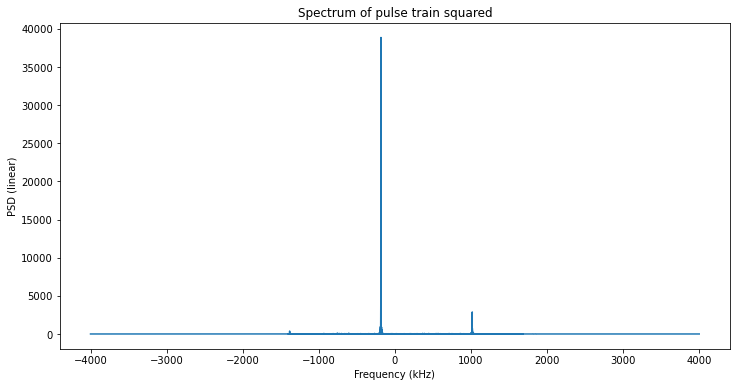

In [18]:
fx = np.abs(np.fft.fft(x**2))**2
freqs = np.fft.fftfreq(fx.size, 1/fs)
plt.plot(np.fft.fftshift(freqs)*1e-3, np.fft.fftshift(fx))
plt.title('Spectrum of pulse train squared')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (linear)')
f_offset = freqs[np.argmax(fx)]/2
f_offset

In [19]:
x0 = x * np.exp(-1j*2*np.pi*f_offset/fs*np.arange(x.size)) * np.exp(1j * np.deg2rad(35))
x0_fold = x0[80*avg:] # drop some samples to center the pulses
n = int(fold_t * fs)
x0_fold = x0_fold[:x0_fold.size//n*n].reshape((-1,n))

In [20]:
template = x0_fold[100]
x0_fold_correct = x0_fold.copy()
for j in range(x0_fold.shape[0]):
    candidate = x0_fold[j]
    corr = np.correlate(candidate, template, mode = 'full')
    lag = np.argmax(np.abs(corr)) - template.size + 1
    x0_fold_correct[j] = np.roll(candidate, -lag) * np.exp(-1j*np.angle(corr[np.argmax(np.abs(corr))]))

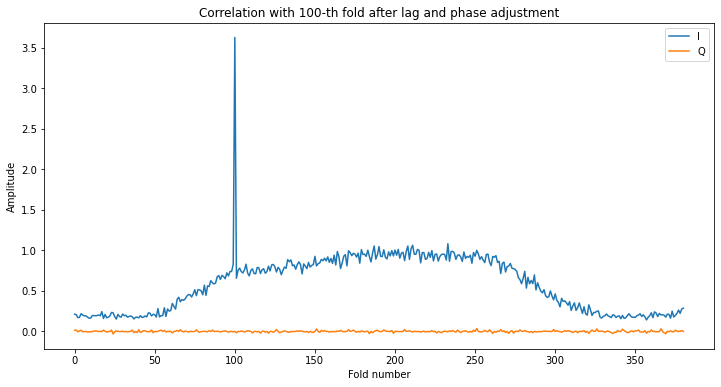

In [21]:
cross = np.sum(x0_fold_correct * np.conjugate(template), axis = 1)
plt.plot(cross.real)
plt.plot(cross.imag)
plt.title('Correlation with 100-th fold after lag and phase adjustment')
plt.legend(['I','Q'])
plt.xlabel('Fold number')
plt.ylabel('Amplitude');

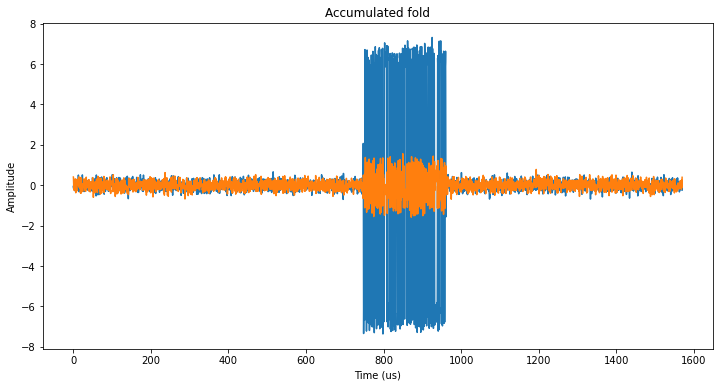

In [22]:
acc = np.sum(x0_fold_correct[50:320], axis = 0)
s = np.arange(acc.size) / fs * 1e6
plt.plot(s, acc.real)
plt.plot(s, acc.imag)
plt.title('Accumulated fold')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude');

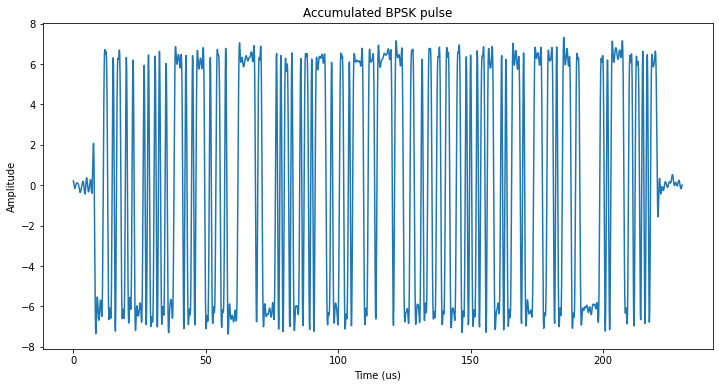

In [23]:
pulse = acc[1480*4:1940*4].real
s = np.arange(pulse.size) / fs * 1e6
plt.plot(s, pulse)
plt.title('Accumulated BPSK pulse')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude');

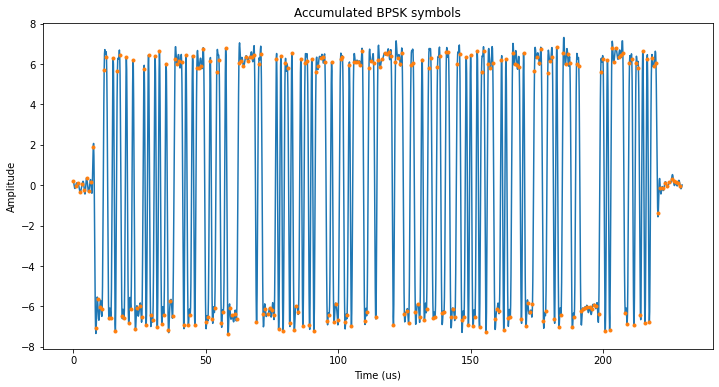

In [24]:
sps = fs/baudrate
tau = np.arange(0, pulse.size-1, sps)
pulse_syms = pulse[np.int32(np.round(tau))]
plt.plot(s, pulse)
plt.plot(s[np.int32(np.round(tau))], pulse_syms, '.')
plt.title('Accumulated BPSK symbols')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude');

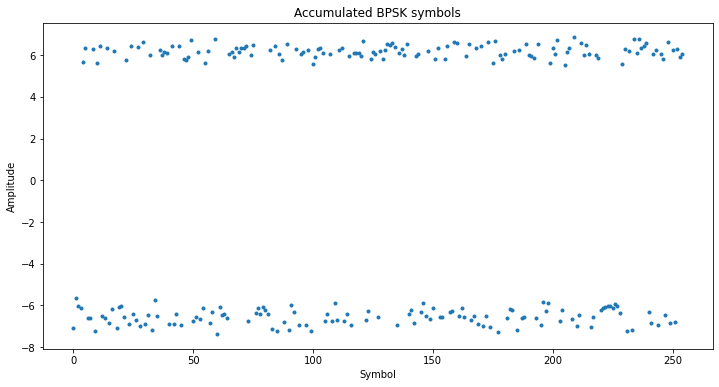

In [25]:
pulse_syms = pulse[np.int32(np.round(tau))]
pulse_syms_crop = pulse_syms[10:-11]
plt.plot(pulse_syms_crop, '.')
plt.title('Accumulated BPSK symbols')
plt.xlabel('Symbol')
plt.ylabel('Amplitude');

In [26]:
sequence = np.sign(pulse_syms_crop)
sequence.size

255

In [27]:
sequence.size/baudrate * 1e6

212.5

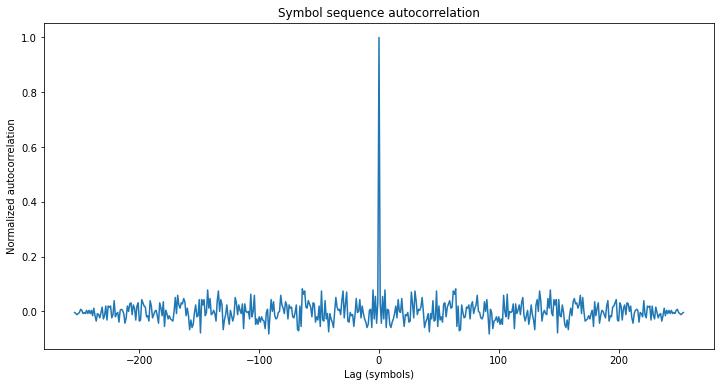

In [28]:
plt.plot(np.arange(-sequence.size+1, sequence.size), np.correlate(sequence, sequence, mode = 'full')/sequence.size)
plt.title('Symbol sequence autocorrelation')
plt.xlabel('Lag (symbols)')
plt.ylabel('Normalized autocorrelation');

The circular autocorrelation shows that this is not a 255-bit M-sequence.

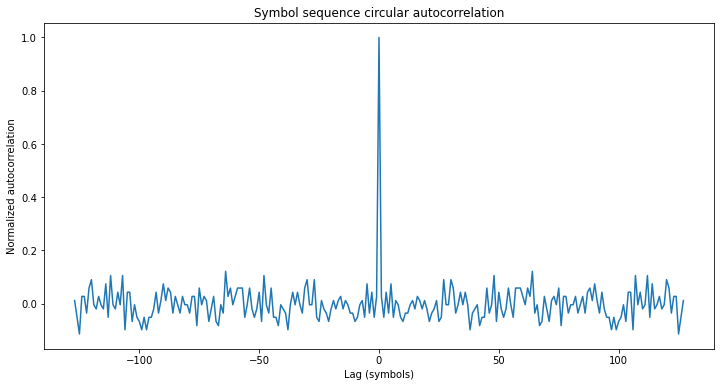

In [29]:
circ_auto = np.fft.fftshift(np.fft.ifft(np.abs(np.fft.fft(sequence))**2).real)
plt.plot(np.fft.fftshift(np.fft.fftfreq(sequence.size, 1/sequence.size)),
         circ_auto/sequence.size)
plt.title('Symbol sequence circular autocorrelation')
plt.xlabel('Lag (symbols)')
plt.ylabel('Normalized autocorrelation');

In [30]:
collections.Counter(np.round(circ_auto).astype('int'))

Counter({3: 18,
         -13: 28,
         -29: 2,
         7: 26,
         -9: 26,
         15: 20,
         23: 6,
         -1: 42,
         -5: 24,
         19: 6,
         27: 6,
         11: 18,
         -25: 8,
         -17: 16,
         -21: 6,
         31: 2,
         255: 1})

In [31]:
np.std(np.fft.fftshift(circ_auto)[:-1])

12.707324618195518

In [32]:
np.sqrt(255)

15.968719422671311

In [33]:
seq = ''.join([str(a) for a in ((sequence+1)//2).astype('int')])
seq

'000011001011001001000010100101001000111101001011110010011001000001111111101100000010101101000101101011111001000110010111110011101111111011110001100010011001100110001100101001011011100010100111101000011110011101001111001100000000011010111111001101101010111'

Interestingly the sequence is not at all balanced:

In [34]:
np.sum(sequence)

7.0

In [41]:
sparse = np.fromfile('meridian_corr_sparse.c64', dtype = 'complex64')
sparse_pos = np.fromfile('meridian_corr_sparse_pos.i32', dtype = 'uint32')
sparse_t = sparse_pos / fs

In [42]:
def peak_finder(t, x, threshold = 1e-3):
    t0, x0 = t[0], x[0]
    for tt, xx in zip(t[1:], x[1:]):
        if tt - t0 > threshold:
            yield t0, x0
            t0, x0 = tt, xx
        elif np.abs(xx) >= np.abs(x0):
            t0, x0 = tt, xx
    yield t0, x0

In [43]:
pf = list(peak_finder(sparse_t, sparse))
peak_t = np.array([p[0] for p in pf])
peak = np.array([p[1] for p in pf])
peak /= np.max(np.abs(peak))

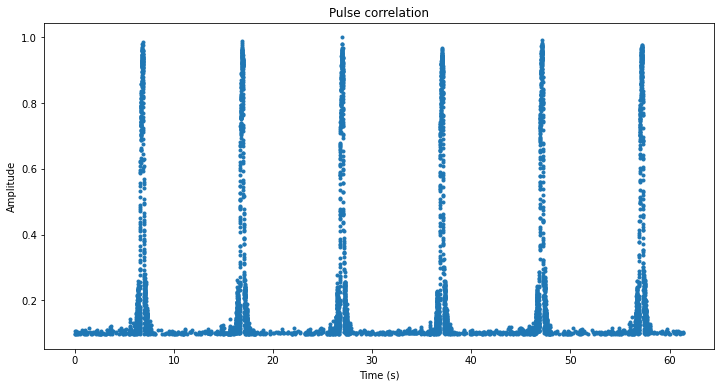

In [44]:
plt.plot(peak_t, np.abs(peak), '.')
plt.title('Pulse correlation')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)');

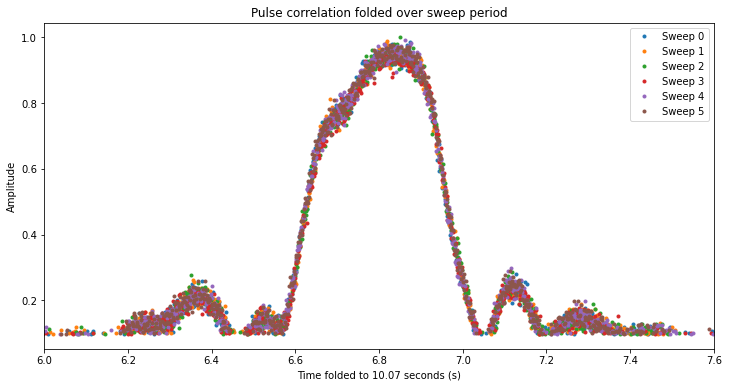

In [45]:
fold_sweep = 10.07
Nsweeps = int(peak_t[-1]/fold_sweep)
for j in range(Nsweeps):
    sel = (peak_t >= j*fold_sweep) & (peak_t < (j+1)*fold_sweep)
    plt.plot(peak_t[sel] % fold_sweep, np.abs(peak[sel]), '.')
plt.xlim(6.0,7.60)
plt.legend([f'Sweep {j}' for j in range(Nsweeps)])
plt.title('Pulse correlation folded over sweep period')
plt.ylabel('Amplitude')
plt.xlabel(f'Time folded to {fold_sweep} seconds (s)');

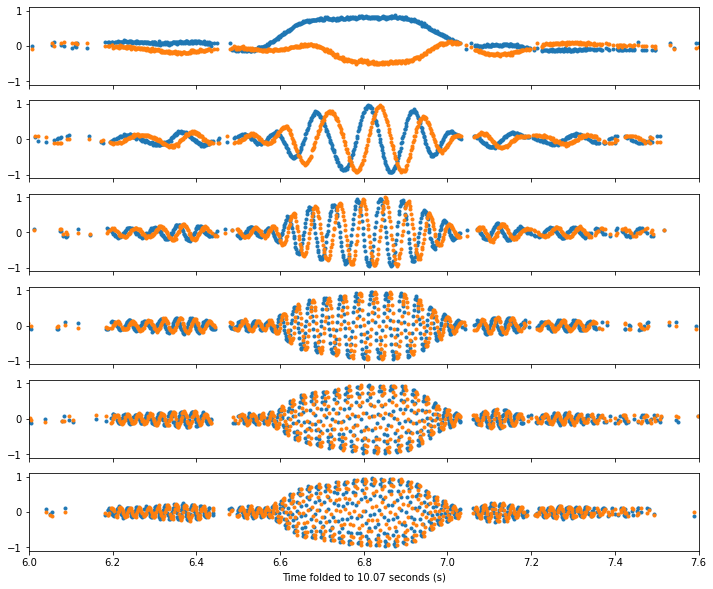

In [46]:
fig, axs = plt.subplots(Nsweeps, 1, sharex = True, figsize = (12,10))
for j in range(Nsweeps):
    sel = (peak_t >= j*fold_sweep) & (peak_t < (j+1)*fold_sweep)
    axs[j].plot(peak_t[sel] % fold_sweep, peak[sel].real, '.')
    axs[j].plot(peak_t[sel] % fold_sweep, peak[sel].imag, '.')
    axs[j].set_xlim(6.0,7.60)
    axs[j].set_ylim(-1.1, 1.1)
axs[-1].set_xlabel(f'Time folded to {fold_sweep} seconds (s)');

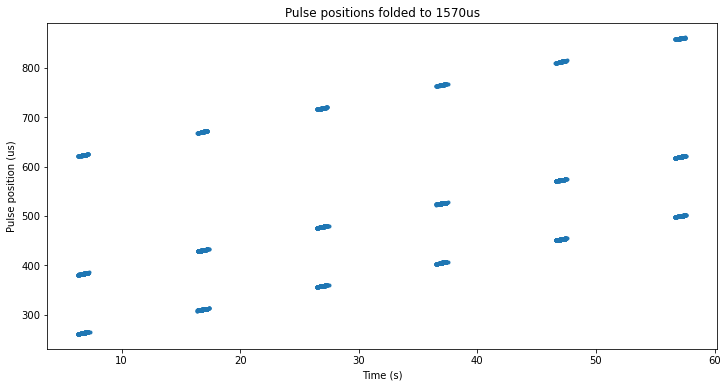

In [47]:
cutoff = np.abs(peak) > 0.17
plt.plot(peak_t[cutoff], (peak_t[cutoff] % fold_t)*1e6, '.')
plt.title('Pulse positions folded to 1570us')
plt.ylabel('Pulse position (us)')
plt.xlabel('Time (s)');

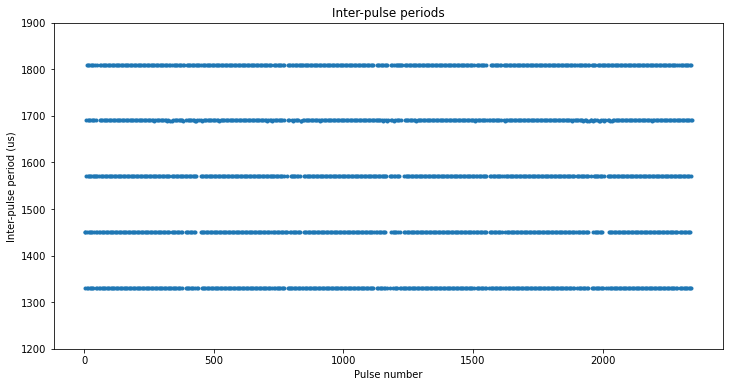

In [48]:
ipp = np.diff(peak_t[cutoff]) # inter-pulse period
plt.plot(ipp * 1e6, '.')
plt.ylim((1200, 1900))
plt.title('Inter-pulse periods')
plt.xlabel('Pulse number')
plt.ylabel('Inter-pulse period (us)');

In [49]:
for cluster in [1350, 1450, 1600, 1700, 1800]:
    sel = np.abs(ipp - cluster*1e-6) < 50e-6
    print(np.average(ipp[sel]*1e6))

1330.0062076748663
1450.0022883296158
1570.0070067263937
1690.009361233514
1810.0106263982634


In [50]:
ipps = np.array([1330, 1450, 1570, 1690, 1810])*1e-6
ipps*1e6 - 1570

array([-240., -120.,    0.,  120.,  240.])

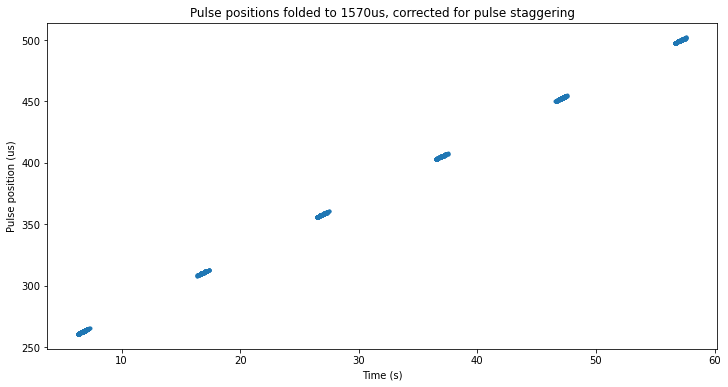

In [51]:
peak_t_5 = peak_t % (5*fold_t)
peak_t_fold = peak_t % fold_t
stagger = [0, 120e-6, 360e-6, 120e-6, 0]
for j in range(5):
    div = (peak_t_5 + 0)/fold_t
    peak_t_fold[(div >= j) & (div < (j+1))] -= stagger[j]
plt.plot(peak_t[cutoff], (peak_t_fold[cutoff])*1e6, '.')
plt.title('Pulse positions folded to 1570us, corrected for pulse staggering')
plt.ylabel('Pulse position (us)')
plt.xlabel('Time (s)');

In [52]:
p = np.polyfit(peak_t[cutoff], peak_t_fold[cutoff], 1)
p[0]*c

1409.2006217682147